In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
HOME = expanduser("~")
import os
import SimpleITK as sitk
from PIL import Image, ImageOps
from scipy.ndimage import rotate
#%matplotlib inline

In [2]:
DIR = os.path.join(HOME, 'programming', 'dk39')
#DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
ORIENTED = os.path.join(DIR, 'preps', 'oriented')
PREALIGNED = os.path.join(DIR, 'preps', 'prealigned')
ALIGNED = os.path.join(DIR, 'preps', 'aligned')
NORMALIZED = os.path.join(DIR, 'preps', 'normalized')
POSTALIGNED = os.path.join(DIR, 'preps', 'postaligned')
PADDED = os.path.join(DIR, 'preps', 'padded')

THUMBNAIL = os.path.join(DIR, 'preps', 'thumbnail')
INPUT = ORIENTED
INPUTS = sorted(os.listdir(INPUT))
BADS = ['DK39_ID_0001_slide001_S1_C1.tif', 'DK39_ID_0007_slide001_S2_C1.tif', 'DK39_ID_0010_slide001_S3_C1.tif']
INPUTS = sorted([i for i in INPUTS if i not in BADS and '_C1' in i])
#INPUTS = INPUTS[80:120]
COLOR = 2**16

In [79]:
def create_initial(fixedImage):
    parameterMap = sitk.GetDefaultParameterMap("rigid")
    parameterMap["Transform"] = ["AffineTransform"]
    elastixImageFilter = sitk.ElastixImageFilter()
    
    elastixImageFilter.SetFixedImage(sitk.GetImageFromArray(fixedImage))
    elastixImageFilter.SetMovingImage(sitk.GetImageFromArray(fixedImage))
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    return elastixImageFilter.GetParameterMap()


def create_merge(fixed_image, moving_image):    
    parameterMap = sitk.GetDefaultParameterMap("rigid")
    parameterMap["Transform"] = ["AffineTransform"]
    elastixImageFilter = sitk.ElastixImageFilter()
    
    #img = sitk.GetImageFromArray(fixed)
    #paddedFixedImage = sitk.ConstantPad(img, (pad, 0), (pad, 0))
    #paddedFixedImage = sitk.ConstantPad(img, (100, 0))
    #fixed = sitk.GetArrayFromImage(paddedFixedImage)
    
    elastixImageFilter.SetFixedImage(fixed_image)
    elastixImageFilter.SetMovingImage(moving_image)
    elastixImageFilter.SetParameterMap(parameterMap)
    elastixImageFilter.Execute()
    #return sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())
    return elastixImageFilter.GetResultImage()

def reg_method(fixed_image, moving_image):

    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=50, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=True)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                   sitk.Cast(moving_image, sitk.sitkFloat32))
    moving_resampled = sitk.Resample(
        moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    #return sitk.GetArrayFromImage(moving_resampled)
    return moving_resampled

In [ ]:
img_outputs = []
file_inputs = []

In [ ]:
img = sitk.GetImageFromArray(img_outputs[2])
paddedFixedImage = sitk.ConstantPad(img, (10, 0), (10, 0))
img = sitk.GetArrayFromImage(paddedFixedImage)

In [82]:
img_outputs = []
file_inputs = []
files = sorted(os.listdir(INPUT))

In [83]:
movingFile = files[0]
file_inputs.append(movingFile)
movingPath = os.path.join(INPUT, movingFile)
fixedPath = movingPath
fixed_image =  sitk.ReadImage(fixedPath, sitk.sitkFloat32)
moving_image = sitk.ReadImage(movingPath, sitk.sitkFloat32) 
fixedImage = reg_method(fixed_image, moving_image)
img_outputs.append(sitk.GetArrayFromImage(fixedImage))
#
movingFile = files[1]
file_inputs.append(movingFile)
movingPath = os.path.join(INPUT, movingFile)
moving_image = sitk.ReadImage(movingPath, sitk.sitkFloat32) 
fixedImage = reg_method(moving_image, fixed_image)
img_outputs.append(sitk.GetArrayFromImage(fixedImage))
#


RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /home/eddyod/programming/build/ITK-prefix/include/ITK-4.13/itkMattesMutualInformationImageToImageMetricv4.hxx:205:
itk::ERROR: MattesMutualInformationImageToImageMetricv4(0x31bb3c0): Joint PDF summed to zero

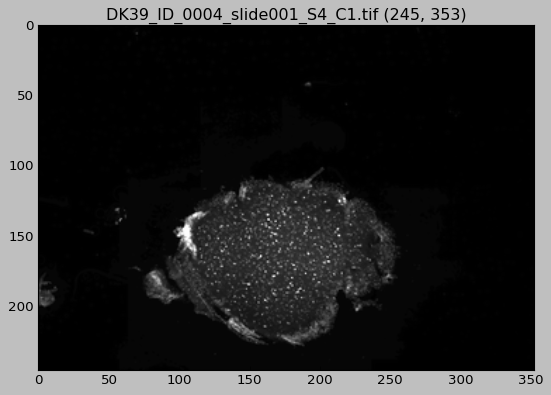

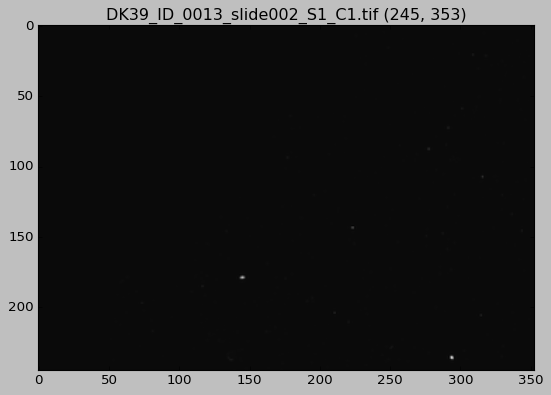

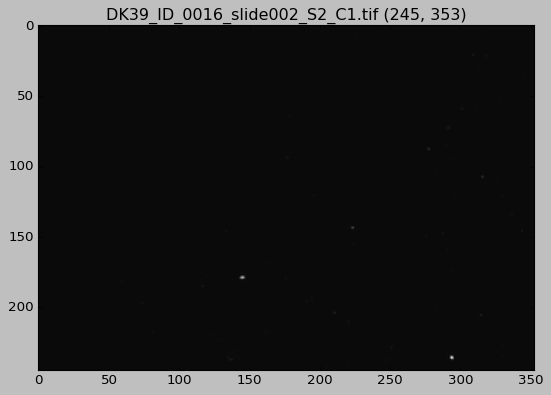

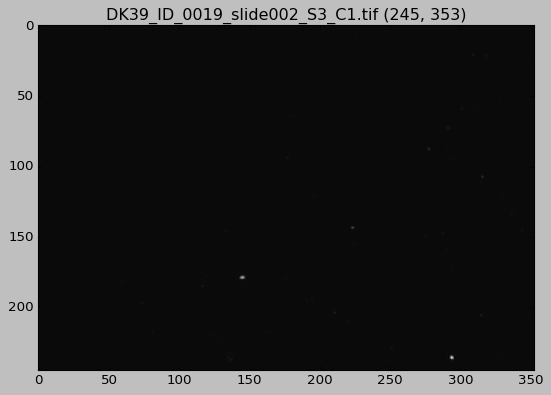

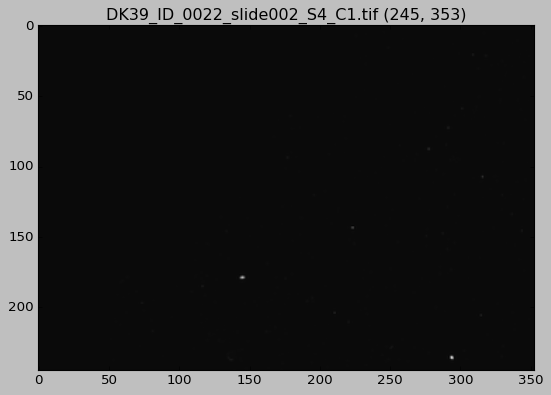

In [68]:
for name,file in zip(file_inputs, img_outputs):
    plt.style.use('classic')
    plt.figure()
    plt.title('{} {}'.format(name, file.shape))
    plt.imshow(file, cmap='gray')
    plt.show()

In [12]:
img_outputs = []
file_inputs = []
INPUTS = sorted(os.listdir(INPUT))
len(INPUTS)

457

In [48]:
img_outputs = []
file_inputs = []
INPUTS = sorted(os.listdir(INPUT))
files = INPUTS[100:120]

movingFile = files[0]
file_inputs.append(movingFile)
movingPath = os.path.join(INPUT, movingFile)
movingImage = io.imread(movingPath)
fixedImage = movingImage
fixedImage = create_merge(movingImage, fixedImage)
img_outputs.append(fixedImage)

for i,movingFile in enumerate(files[1:-1]):
    movingFile = files[i]
    file_inputs.append(movingFile)
    movingPath = os.path.join(INPUT, movingFile)
    movingImage = io.imread(movingPath)
    fixedImage = create_merge(movingImage, fixedImage)
    img_outputs.append(fixedImage)
    
OUTPUT = PREALIGNED
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

for filename,fixedImage in zip(file_inputs, img_outputs):
    outfile = os.path.join(OUTPUT, filename)
    flat = fixedImage.flatten()
    fmax = int(flat.max())
    fmin = int(flat.min())
    flat = flat + abs(fmin)
    img = np.reshape(flat, fixedImage.shape)    
    io.imsave(outfile, img.astype('uint16'), check_contrast=False)

In [ ]:
data = []
file_inputs = []
INPUTS = sorted(os.listdir(INPUT))
files = INPUTS
for movingFile in files:
    file_inputs.append(movingFile)
    movingPath = os.path.join(INPUT, movingFile)
    data.append(sitk.ReadImage(movingPath))

In [ ]:
dimension = data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()
reference_size = [1738]*dimension # Arbitrary sizes, smallest size that yields desired results. 
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [ ]:
img_outputs = []
for img in data:
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth 
    # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that 
    # no new labels are introduced.
    new_img = sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    new_img = sitk.GetArrayFromImage(new_img)
    img_outputs.append(new_img)
    #sitk.Show(sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0))

In [ ]:
type(img_outputs[0])

In [ ]:
for i in range(0,1):
    plt.style.use('classic')
    plt.figure()
    plt.title(img_outputs[i].shape)
    plt.imshow(img_outputs[i], cmap='gray')
    plt.show()


In [17]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    #plt.imshow(fixed_npa[fixed_image_z,:],cmap=plt.cm.Greys_r);
    plt.imshow(fixed_npa,cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa,cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [31]:
def get_max_size(INPUT):
    widths = []
    heights = []
    files = os.listdir(INPUT)
    for file in files:
        img = io.imread(os.path.join(INPUT, file))
        heights.append(img.shape[0])
        widths.append(img.shape[1])

    max_width = max(widths)
    max_height = max(heights)

    return max_width, max_height
max_width, max_height = get_max_size(INPUT)

In [32]:
OUTPUT = PREALIGNED
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

img_outputs = []
file_inputs = []
files = sorted(INPUTS)
stop = len(INPUTS) - 1
files.insert(0,INPUTS[0])
for i, file in enumerate(files):
    if i == stop:
        break
    movingFile = files[i]
    movingPath = os.path.join(INPUT, movingFile)
    fixedFile = files[i+1]
    fixedPath = os.path.join(INPUT, fixedFile)
    file_inputs.append(file)

    fixed_image =  sitk.ReadImage(fixedPath, sitk.sitkFloat32)
    moving_image = sitk.ReadImage(movingPath, sitk.sitkFloat32) 
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

    moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    img = sitk.GetArrayFromImage(moving_resampled)
    img_outputs.append(img)
    
    
zmidr = max_height // 2
zmidc = max_width // 2

for filename,fixedImage in zip(file_inputs, img_outputs):
    outfile = os.path.join(OUTPUT, filename)
    flat = fixedImage.flatten()
    fmax = int(flat.max())
    fmin = int(flat.min())
    flat = flat + abs(fmin)
    img = np.reshape(flat, fixedImage.shape)    
    
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.zeros([max_height, max_width], dtype=np.uint16)
    new_img[startr:endr,startc:endc] = img
    
    
    io.imsave(outfile, new_img.astype('uint16'), check_contrast=False)    
    new_img = None


In [14]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

#interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[1]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

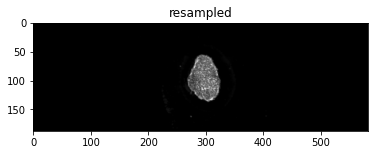

In [33]:
img = sitk.GetArrayFromImage(moving_resampled)
plt.figure()
plt.title('resampled')
plt.imshow(img, cmap='gray')
plt.show()

In [51]:
OUTPUT = PREALIGNED
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

img_outputs = []
file_inputs = []
files = sorted(INPUTS[0:5])
stop = len(files) - 1
files.insert(0,INPUTS[0])
for i, file in enumerate(files):
    if i == stop:
        break
    movingFile = files[i+1]
    movingPath = os.path.join(INPUT, movingFile)
    fixedFile = files[i]
    fixedPath = os.path.join(INPUT, fixedFile)
    file_inputs.append(file)
    img = reg_method(fixedPath, movingPath)
    img_outputs.append(img)


RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: /home/eddyod/programming/build/ITK-prefix/include/ITK-4.13/itkMattesMutualInformationImageToImageMetricv4.hxx:205:
itk::ERROR: MattesMutualInformationImageToImageMetricv4(0x2e2ba10): Joint PDF summed to zero

In [21]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.5352547650550208
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 61.


In [22]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

In [23]:
new_img = sitk.GetArrayFromImage(moving_resampled)
fixed_image_array = sitk.GetArrayFromImage(fixed_image)
moving_image_array = sitk.GetArrayFromImage(moving_image)

In [ ]:
fixed_image_array.shape

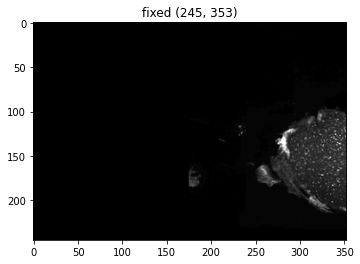

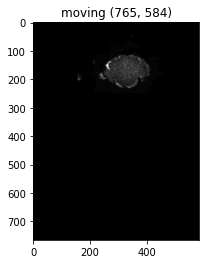

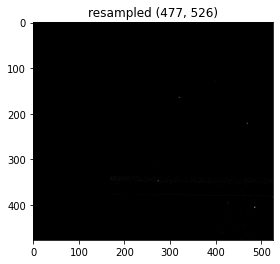

In [38]:
fixed_image_array = img_outputs[0] 
moving_image_array = img_outputs[1] 
new_img = img_outputs[2] 

plt.figure()
plt.title('fixed {}'.format(fixed_image_array.shape))
plt.imshow(fixed_image_array, cmap='gray')
plt.show()
#
plt.figure()
plt.title('moving {}'.format(moving_image_array.shape))
plt.imshow(moving_image_array, cmap='gray')
plt.show()
#
plt.figure()
plt.title('resampled {}'.format(new_img.shape))
plt.imshow(new_img, cmap='gray')
plt.show()